In [1]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

#pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

W0527 13:30:12.414528   900 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'fireHD-tag'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text','main']]
###################################################

In [3]:
import re

def remove_banned(s,words):
    #words = sorted(words, key=len, reverse=True)
    pattern = '|'.join(words)
    s = re.sub(pattern, '', s, flags = re.I) # remove words
    s = re.sub(r'[0-9]+', '', s) # remove numbers
    s = re.sub('\s+', ' ', s, flags = re.I) # remove extra blank space'
    return s

bannedWords = ['hi', 'hi you', 'hello', 'and you']
s = "Hi, Hello, hi you, How are Tim and you doing"

print(remove_banned(s,bannedWords))

, , you, How are Tim doing


In [4]:
word_list = pd.read_csv('sentiment/wordlist.csv')
word_list = word_list.dropna()
word_list['count'] = word_list['word'].apply(lambda x: len(x.split()))
wd2 = word_list

In [5]:
word_list = word_list.sort_values(by=['count'],ascending =False).reset_index(drop=True)
word_list['word'] = word_list['word'].apply(lambda x: x+' ')
wordlist = word_list.loc[word_list['count']<10, ['word']]
wordlist = wordlist['word'].tolist()

In [6]:
one_word = wd2[wd2['count']==1]['word'].tolist()
mylist = ['love','loves','loved','like','likes','liked','enjoy','enjoys','enjoyed',
            'hate','hates','hated','do','does','did','don','don\'t','want','wants','wanted']
subject = ['kindle','paperwhite','fire']
one_word.extend(mylist)
one_word.extend(subject)
one_word = set(one_word)

In [7]:
def clean_review(x):

    words = one_word

    resultwords  = [word for word in re.split("[.,; :-?!&]+",x) if word.lower() not in words]
    result = ' '.join(resultwords)
    return result

In [8]:
for i in range(len(wordlist)):
    if wordlist[i]=='love ':
        print('in')
        
print('finished')

in
finished


In [9]:
reviews['removed'] = reviews['text'].apply(lambda x: remove_banned(x,wordlist))
reviews['removed'] = reviews['text'].apply(lambda x: clean_review(x))

In [10]:
def clean_punct(line):
    line = re.sub('[0-9%]+','',line)
    line = re.sub(' +', ' ',line)
    return line.strip()

In [11]:
test_str = "34 34 aaa bbb, 100% good. Don't be sad."
clean_punct(test_str)

"aaa bbb, good. Don't be sad."

In [12]:
reviews['removed'] = reviews['removed'].apply(lambda x: clean_punct(x))

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import islice


In [14]:
cvec = CountVectorizer(stop_words='english', min_df=0.001, max_df=.2, ngram_range=(2,3))
cvec.fit(reviews.removed)
len(cvec.vocabulary_)
#list(islice(cvec.vocabulary_.items(), 20))

133

In [15]:
cvec_counts = cvec.transform(reviews.text)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
#counts_df.sort_values(by='occurrences', ascending=False).head(20)

sparse matrix shape: (3355, 133)
nonzero count: 738
sparsity: 0.17%


In [16]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=False).reset_index(drop=True)

In [17]:
key_words = weights_df[weights_df.weight>=0.0005]

In [18]:
len(key_words)

127

In [19]:
key_words

,term,weight
0,battery life,0.010422
1,wi fi,0.005124
2,customer service,0.005067
3,read books,0.004790
4,learning use,0.004639
5,play games,0.003856
6,christmas gift,0.003618
7,couldn happier,0.002886
8,reading books,0.002708
9,bought son,0.002585


In [20]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

In [21]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)


Instructions for updating:
Colocations handled automatically by placer.


W0527 13:31:24.780227   900 deprecation.py:323] From C:\Users\betty\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [22]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    key_words['embedding'] = pd.Series(list(session.run(embed(list(key_words['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 13:31:46.830368   900 saver.py:1483] Saver not created because there are no variables in the graph to restore
C:\Users\betty\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


time1: 3.3031222820281982


In [23]:
terms = key_words['term'].tolist()
embs = key_words['embedding'].tolist()

In [24]:
##
X = np.array(embs,)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(embs)

In [25]:
X.shape

(127, 512)

In [26]:
import matplotlib.pyplot as plt

labels = terms 
plt.figure(figsize=(10, 7))  
plt.subplots_adjust(bottom=0.1)  
plt.scatter(X2[:,0],X2[:,1], label='True Position')

for label, x, y in zip(labels, X2[:, 0], X2[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()  

<Figure size 1000x700 with 1 Axes>

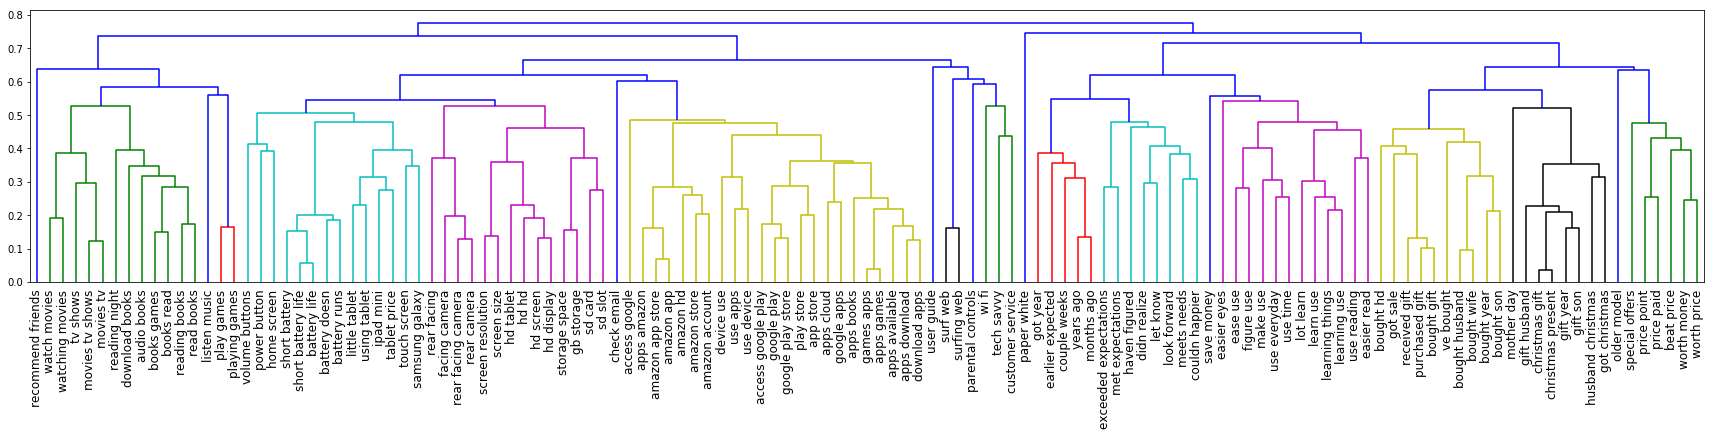

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist

#dist_condensed = pdist(X)
#linked = linkage(X, 'single',metric='cosine',optimal_ordering=True)
linked = linkage(X, 'average', metric='cosine',optimal_ordering=True)
labelList = terms

plt.figure(figsize=(30, 5))  
dh = dendrogram(linked,  
            orientation='top',
            labels=labelList,
            leaf_font_size=12,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [28]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.21.2.


In [86]:
import matplotlib.pyplot as plt  
import pandas as pd  
%matplotlib inline
import numpy as np  
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold =0.45)  
term_clusters = cluster.fit_predict(X)  
term_clusters

array([13, 24,  2, 10, 17, 11, 20,  7, 10,  4,  9, 30,  0,  0, 12, 23, 14,
       22, 14, 20,  0, 16, 10, 30, 15,  2,  6,  8, 34,  5, 35,  6, 31,  4,
        0, 11, 19,  7,  9,  5, 14, 16,  1,  4, 14,  9,  3, 20, 20, 21,  1,
       34,  0,  0, 27,  1,  5,  3, 26,  1, 25, 14,  3, 18,  7, 14, 17,  1,
        4,  9, 33,  6,  0, 10, 26, 29,  3, 16, 10, 13, 32,  0, 17, 15,  7,
        0,  0, 12,  3, 36, 17,  7, 10, 22, 22, 20, 12, 10,  9, 34, 13, 34,
        6, 16, 15, 15, 15, 13,  0,  6, 34,  0,  0, 20,  0, 22, 12, 12,  0,
       15,  8, 13, 28,  0, 34,  4, 20], dtype=int64)

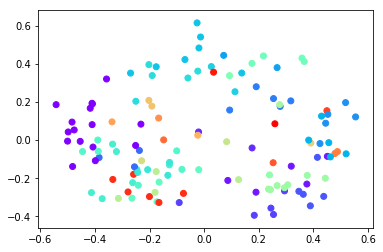

In [87]:
plt.scatter(X2[:,0],X2[:,1], c=cluster.labels_, cmap='rainbow') 

In [88]:
cluster_numbers = np.amax(term_clusters)
print('Number of keyword clusters:',cluster_numbers)

Number of keyword clusters: 36


In [89]:
cluster_data = {'term':terms, 'cluster':term_clusters}
df_cluster = pd.DataFrame(cluster_data)

In [91]:
#df_cluster.to_csv("output/kindle_keywords.csv",index=False)
####### load
df_cluster = pd.read_csv("output/kindle_keywords.csv")

In [90]:
group = []
for i in range(cluster_numbers+1):
    terms_in_group = df_cluster.loc[df_cluster['cluster']==i]['term'].tolist()
    if len(terms_in_group)>=3:
        group.append(terms_in_group)
        print('Group '+str(i)+':\n',terms_in_group,'\n')

Group 0:
 ['google play', 'app store', 'apps available', 'google apps', 'apps cloud', 'games apps', 'play store', 'use device', 'apps games', 'apps books', 'google play store', 'download apps', 'device use', 'use apps', 'apps download', 'access google play'] 

Group 1:
 ['worth money', 'price point', 'worth price', 'price paid', 'beat price'] 

Group 3:
 ['bought gift', 'bought hd', 'purchased gift', 'got sale', 'received gift'] 

Group 4:
 ['bought son', 'bought husband', 've bought', 'bought wife', 'bought year'] 

Group 5:
 ['volume buttons', 'power button', 'home screen'] 

Group 6:
 ['use time', 'ease use', 'use everyday', 'figure use', 'make use'] 

Group 7:
 ['couldn happier', 'meets needs', 'let know', 'look forward', 'didn realize'] 

Group 9:
 ['years ago', 'months ago', 'earlier expected', 'couple weeks', 'got year'] 

Group 10:
 ['read books', 'reading books', 'download books', 'reading night', 'books read', 'books games', 'audio books'] 

Group 12:
 ['watch movies', 'watch

In [92]:
test1 = group[1]
test1

['worth money', 'price point', 'worth price', 'price paid', 'beat price']

In [93]:
ar1 = np.array([1,2,3,4,5])
ar2 = np.array([2,3,4,5,6])
ar3 = (ar1+ar2)/2
ar3

array([1.5, 2.5, 3.5, 4.5, 5.5])

In [94]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [95]:
avg_embs = []
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    
    for word_group in group:
        temp_embs = np.array(session.run(embed(word_group)))
        temp_avg = np.zeros(len(temp_embs[0]))
        for term_emb1 in temp_embs:
            temp_avg = temp_avg+term_emb1
        term_avg = temp_avg/len(word_group)
        avg_embs.append(term_avg)
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:11:44.251040   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:11:47.943655   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:11:52.019928   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:11:56.606353   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:12:02.517012   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:12:09.091380   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:12:16.190929   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:12:24.306383   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:12:33.716720   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:12:43.962343   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:12:55.349213   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:13:08.751834   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:13:22.684003   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:13:37.960776   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:13:54.611655   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:14:13.028981   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:14:33.092058   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0527 14:14:57.023438   900 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 219.2972137928009


In [97]:
data2 = {'terms':group, 'avg_emb':avg_embs}
cluster_embs = pd.DataFrame(data2)
cluster_embs

,terms,avg_emb
0,"[google play, app store, apps available, googl...","[-0.004011161458038259, -0.0006794111832277849..."
1,"[worth money, price point, worth price, price ...","[0.03527634814381599, 0.016698149498552084, -0..."
2,"[bought gift, bought hd, purchased gift, got s...","[-0.0075700411573052405, 0.011954342387616635,..."
3,"[bought son, bought husband, ve bought, bought...","[0.03638896523043513, 0.0066331471782177685, -..."
4,"[volume buttons, power button, home screen]","[-0.04336073684195677, -0.017115998702744644, ..."
5,"[use time, ease use, use everyday, figure use,...","[0.021161016076803207, 0.015681715711252764, 0..."
6,"[couldn happier, meets needs, let know, look f...","[0.03414165154099465, -0.014147660648450255, -..."
7,"[years ago, months ago, earlier expected, coup...","[-0.024673844501376153, -0.0026353015564382076..."
8,"[read books, reading books, download books, re...","[-0.004771817309249725, 0.020882067187423154, ..."
9,"[watch movies, watching movies, movies tv, mov...","[-0.024579526856541634, -0.0075764037435874345..."


In [98]:
import pickle
pickle.dump(cluster_embs, open("output/kindle_cluster_embs.pickle", "wb"))

In [99]:
test_load = pickle.load(open("output/kindle_cluster_embs.pickle", "rb"))
test_load

,terms,avg_emb
0,"[google play, app store, apps available, googl...","[-0.004011161458038259, -0.0006794111832277849..."
1,"[worth money, price point, worth price, price ...","[0.03527634814381599, 0.016698149498552084, -0..."
2,"[bought gift, bought hd, purchased gift, got s...","[-0.0075700411573052405, 0.011954342387616635,..."
3,"[bought son, bought husband, ve bought, bought...","[0.03638896523043513, 0.0066331471782177685, -..."
4,"[volume buttons, power button, home screen]","[-0.04336073684195677, -0.017115998702744644, ..."
5,"[use time, ease use, use everyday, figure use,...","[0.021161016076803207, 0.015681715711252764, 0..."
6,"[couldn happier, meets needs, let know, look f...","[0.03414165154099465, -0.014147660648450255, -..."
7,"[years ago, months ago, earlier expected, coup...","[-0.024673844501376153, -0.0026353015564382076..."
8,"[read books, reading books, download books, re...","[-0.004771817309249725, 0.020882067187423154, ..."
9,"[watch movies, watching movies, movies tv, mov...","[-0.024579526856541634, -0.0075764037435874345..."


In [ ]:
####### corr
corr = np.inner(embs,embs)

In [ ]:
corr[7][26]

In [ ]:
corr[corr<0]=0
corr[corr>0.99]=0

In [ ]:
result = np.where(corr == np.amax(corr))
result[0]

In [ ]:
n_sentence = len(terms)
corr_maxes = np.amax(corr,axis=1)
corr_mins = np.amin(corr,axis=1)
avg_corr = sum(sum(corr))/n_sentence/n_sentence
avg_max_corr = sum(corr_maxes) / n_sentence
avg_min_corr = sum(corr_mins) / n_sentence
print('avg max corr:{}, avg min corr:{}. avg corr:{}'.format(avg_max_corr, avg_min_corr, avg_corr))

In [ ]:
# Clustering
time1 = time.time()
db_w = DBSCAN(eps=0.25, metric='cosine').fit(embs)
print('time for clustering sentence embeddings:', (time.time()-time1))
# Get labels
labels_w = db_w.labels_.tolist()
key_words['label'] = labels_w
key_words

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

plot_similarity(np.array(key_words['term'].tolist()),np.array(key_words['embedding'].tolist()),90)

In [ ]:
print(reviews['text'][1193])
print(reviews['text'][1648])

In [ ]:
corr_maxes = np.amax(corr,axis=1)
corr_mins = np.amin(corr,axis=1)
avg_corr = sum(sum(corr))/n_sentence/n_sentence
avg_max_corr = sum(corr_maxes) / n_sentence
avg_min_corr = sum(corr_mins) / n_sentence
print('avg max corr:{}, avg min corr:{}. avg corr:{}'.format(avg_max_corr, avg_min_corr, avg_corr))

In [ ]:
corr_min_of_max = np.amin(corr_maxes)
corr_min_of_max

In [ ]:
np.amax(corr)

In [ ]:
labels = np.zeros(shape=n_sentence, dtype=np.int8)
chain = np.zeros(shape=n_sentence, dtype=np.int8)

the_line = 0.85#0.9*avg_max_corr+0.1*avg_corr
the_line

In [ ]:
np.where(corr > the_line)[0].shape[0]/(n_sentence*n_sentence)

In [ ]:
pairs = np.where(corr > 0.85)

In [ ]:
my_i=4
print(reviews['text'][pairs[0][my_i]])
print(reviews['text'][pairs[1][my_i]])

In [ ]:
def find_close_pt_with_label(s): # s: the index of the sentence
    for i in range(0, n_sentence):
        if corr[s][i]>the_line and labels[i]!=0:
            return i,labels[i]
    return 0, 0

def group_labels(labels):
    clusters = []
    for i in range(-1,np.amax(labels)):
        index = np.where(labels == i)
        clusters.append(index[0])
    return clusters

In [ ]:
label_count = 1
current_label=0

for i in range(0,n_sentence):
    if np.amax(corr[i])<0.85:
        labels[i] = -1 
        continue
    #######check if we should skip to next ####################
    if labels[i]!= 0: # if i already has a label
        continue
    ######or need to find the current sentence a label########
    else:
        (index_, temp) = find_close_pt_with_label(i) # try to find i an existing label
        if temp!=0:
            labels[i] = temp
            chain[i] = 1+chain[index_]
            if chain[i]>1: #1: # does not allow 2+ chain
                labels[i] = label_count
                label_count = label_count+1
        else:
            labels[i] = label_count # else, assign a new label
            label_count = label_count+1
    ###### finished assigning the current sentence a label#########
    
    current_label = labels[i]
    ###### move on to spread the label  ###########################
    for j in range(i, n_sentence):
        if labels[j]!=0: # if j already has a label
            continue # skip
        if corr[i][j]>the_line: # if sentence i is similar to sentence j enough
            if labels[j]==0: # if sentence j doesn't have a label
                labels[j] = current_label
                

In [ ]:
clusters = group_labels(labels)

In [ ]:
len(clusters)

In [ ]:
clusters

In [ ]:
clusters[1].shape[0]

In [ ]:
loose = []
remove_group = []
for i in range(0,len(clusters)):
    if clusters[i].shape[0]<10:
        for j in range(0,clusters[i].shape[0]):
            loose.append(clusters[i][j])
        remove_group.append(i)
        
loose = np.array(loose)

In [ ]:
clusters = np.array(clusters)
clusters = np.delete(clusters, remove_group, 0)
clusters = clusters.tolist()
clusters.append(loose)

In [ ]:
clusters

In [ ]:
##############save##############
product_title='Fire HD'
params='greedy-cosine'
dir1 = save_results_dir(product_title,'similarity',params+'/sentence')
make_or_clean_dir(dir1)
for i in range(0,len(clusters)):    
    temp = reviews.loc[clusters[i].tolist(),['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')

#################################

In [ ]:
pca = dc.PCA(n_components=10)
pca.fit(X1)
X1 = pca.transform(X1)

pca = dc.PCA(n_components=10)
pca.fit(X2)
X2 = pca.transform(X2)

n_sentence = len(X2.tolist())
import math
n_min_pts = math.ceil(n_sentence*0.01)

print('number of sentences:{}, min points:{}'.format(n_sentence,n_min_pts))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

plot_similarity(np.array(reviews['text'].tolist())[0:50],np.array(reviews['sentence_embedding'].tolist())[0:50],90)

In [ ]:
label_s = np.array([])
label_w = np.array([])


def cluster_number(labels):
    return (len(set(labels)) - (1 if -1 in labels else 0))



In [ ]:
print('total sentences:',len(list(labels_s)))
print('clusters for sentences:',n_sentence, 'noise:',list(labels_s).count(-1))
print('clusters for words:',n_words, 'noise:',list(labels_w).count(-1))

In [ ]:
def save_results_dir(product_name, method, params):
    dir_pre = '/home/betty35/桌面/Capstone/workspace/data_testing/output/'
    dir_ = dir_pre+product_name+'/'+method+'/'+params+'/'
    return dir_


def make_dir(dir_):
    if not os.path.exists(dir_):
        try:
            os.makedirs(dir_)
        except FileExistsError:
            pass

def clean_dir(dir_):
    for file_ in os.listdir(dir_):
        file_dir = os.path.join(dir_, file_)
        try:
            if os.path.isfile(file_dir):
                os.unlink(file_dir)
            elif os.path.isdir(file_dir): shutil.rmtree(file_dir)
        except Exception as e:
            print(e)

def make_or_clean_dir(dir_):
    make_dir(dir_)
    clean_dir(dir_)
    

In [ ]:
product_title='Fire HD'
params='0.27-PCA10'
dir1 = save_results_dir(product_title,'dbscan',params+'/sentence')
make_or_clean_dir(dir1)
for i in range(0,n_sentence):    
    temp = reviews.loc[reviews['label_db_sentence']==i,['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')

noise_s = temp = reviews.loc[reviews['label_db_sentence']==-1,['text']] 
np.savetxt(r''+dir1+'noise.txt', temp.values, fmt='%s')

dir1 = save_results_dir(product_title,'dbscan',params+'/word')
make_or_clean_dir(dir1)
for i in range(0,n_words):
    temp = reviews.loc[reviews['label_db_word']==i,['text']]
    file_name = str(i)+'.txt'
    np.savetxt(r''+dir1+file_name, temp.values, fmt='%s')
noise_s = temp = reviews.loc[reviews['label_db_word']==-1,['text']] 
np.savetxt(r''+dir1+'noise.txt', temp.values, fmt='%s')

In [ ]:
def cal_distance(X250):
    